<a href="https://colab.research.google.com/github/TheiloT/RL-accelerated-cart/blob/main/accelerated_cart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This first cell installs stable-baselines3 and its dependencies and downloads the source code to execute the notebook.
!pip install stable-baselines3==2.0.0a5 gymnasium==0.28.1
!git clone https://github.com/TheiloT/RL-accelerated-cart.git

In [2]:
import time
import numpy as np
from scipy.optimize import minimize
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

import sys; sys.path.append('RL-accelerated-cart')
from utils import *
import params
from params import *
from analytical import *
from problem import *
from dp_rl import *

% LaTeX macros...
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathbb{N}}$
$\renewcommand{\P}{\mathcal{P}}$
$\newcommand{\U}{\mathcal{U}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\x}{\mathbf{x}}$
$\renewcommand{\v}{\mathbf{v}}$
$\renewcommand{\u}{\mathbf{u}}$
$\newcommand{\bigO}{\mathcal{O}}$
$\newcommand{\mat}{\mathrm}$
$\newcommand{\tf}{\mathbf}$
$\newcommand{\ts}{\mathtt}$
$\newcommand{\dd}{\, \mathrm{d}}$
$\newcommand{\d}{\mathrm{d}}$
$\newcommand{\T}{\mathrm{T}}$
$\newcommand{\intset}[2]{\{#1, ..., #2\}}$

Notations:
- Scalars and vectors are denoted in lower case letters: $x$, $y$;
- Scalar- and vector-valued functions of time are denoted in bold lower case letters: $\tf x$, $\tf y$;
- Time series (and vectors interpreted as such) are denoted in teletype font: $\ts x$;
- Matrices are denoted by upright capital letters: $\mat A$;
- If $y$ is a column vector, $y^\T$ is the corresponding row vector;
- $\mat A^\T$ is the transpose of $\mat A$;
- $\dot{\tf x}$ and $\ddot{\bf x}$ are the first and second derivatives in time of $\tf x$;
- $\langle x, x' \rangle$ is the inner product between $x$ and $x'$.

# Introduction

In this notebook, we discuss some motivations for the use of RL (Reinforcement Learning) for online problems, especially problems for which the model is not fully known and the initial conditions are not known in advance. We do so by solving a linear toy-problem with simple but classical approaches from optimal control theory on the one hand, and with a standard algorithm from RL on the other hand. By comparing the two methods, we hope to illustrate how the two paradigms differ in their approach to tackling the problem, so as to highlight the strengths of RL over the somewhat rigid approaches from optimal control theory. In particular, we illustrate how RL can work model-free, mitigate the curse of dimensionality intrinsic to dynamic programming and offer computational gains for real-time problems. But we will also hihghlight the data inefficacy of RL. 

The procedure applied decomposes as follows:
1. The problem is presented.
2. An analytical solution is derived for comparison.
3. The dynamics are discretized in time to derive a numerical simulator that will represent the system we interact with.
4. The problem is solved using the adjoint method.
5. The problem is solved with dynamic programming.
6. The problem is moved to an RL framing and solved using algorithms from RL.

---

# Introduction of the toy problem

Let's consider a small but typical problem. We have a system, for example a cart, that can move along a 1D axis $x$. We want to bring this cart from an initial position $x_0$ to a target position, namely $x = 0$, in finite time $T$ by exerting a force that we which to minimize.

More precisly, the cart is assimilated to a mechanical point of mass $m > 0$ and its position is denoted by $x \in \Omega = \R$. The initial position is drawn uniformly randomly in $\Omega_0 = [-1, 0]$ and the initial velocity is null. The force we apply on the cart at a given instant is denoted by $u \in U = \R$, and we are looking for a control that maps any time $t \in [0, T]$ to an action in $U$; this control is denoted by $\tf u \in \U = L^2\big( [0, T], U \big)$. The dynamics of the system write:
$$
    \begin{cases}
        m \ddot{\tf x}(t) = \tf u(t) & \forall t \in [0, T],\\
        \tf x(0) = x_0,\\
        \dot{\tf x}(0) = 0,
    \end{cases}
$$
and we want to find $u$ that optimizes the cost functional $J$:
$$
    \min_{\tf u \in \U} J(\tf u)
$$
where
$$
    J(\tf u) = \lambda_P \tf x(T)^2 + \lambda_V \dot{\tf x}(T)^2 + \int_0^T \tf u(t)^2 \dd t
$$
with $\lambda_P,\, \lambda_V > 0$ two parameters that set the penalizations for not reaching the target a time $T$ and not making the cart motionless at $T$ respectively. One interpretation could be that we have some tolerance on the final position; we can stop instantaneously at time $T$ but this damages the cart's brakes; and exerting a force on the cart has some energy cost.

For convenience, in what follows, we will also denote by $\V = \R$ the space of velocity.

Before going further, let's characterize this problem a bit. Appart from the stochastic initial condition, it is deterministic. It is of fixed time-horizon and it is continuous in time. The fact that we add some penalization on the final state makes it a problem with a "long-time" return, in the sense that a large portion of the cost comes at the very end of the evolution process; but at the same time, penalization on the intensity of the force introduces intermediary costs along a trajectory.

The default values for the parameters of the problem are defined in file `params.py` and are the following:

In [3]:
def refresh_parameters():
    global M_REAL, LAMBDA_P, LAMBDA_V, T, N, DT, U_L, U_R, N_U, DU, V_L, V_R, DV, N_V, X_L, X_R, DX, N_X
    M_REAL = params.M_REAL
    LAMBDA_P = params.LAMBDA_P
    LAMBDA_V = params.LAMBDA_V
    T = params.T
    N = params.N
    DT = params.DT
    U_L, U_R = params.U_L, params.U_R
    N_U = params.N_U
    DU = params.DU
    V_L, V_R = params.V_L, params.V_R
    N_V = params.N_V
    DV = params.DV
    X_L, X_R = params.X_L, params.X_R
    N_X = params.N_X
    DX = params.DX    

In [4]:
print_current_parameters()

M_REAL: 1
LAMBDA_P: 100
LAMBDA_V: 50
T: 1


## Assumption

Note also that this problem is already formulated as a continuous optimal control problem with a known model. In what follows we will use this model to define a simulator to represent the system that we want to control. In practice, and especially for real physical systems, you wouldn't have such a simulator (or you'd try to implement one, which requires already having a precise model for the system). Therefore, unless stated otherwise, __we assume that we do not know the underlying model for this system__. In other words, the simulator that comes next can be thought of as a physical system that we can interact with and measure with infinite precision.

In particular, we will consider $m$ as an unknown parameter of the problem. However; $\lambda_P$ and $\lambda_V$ are suppsoed to be known because they set the objective that we want to optimize. This is actually a strong hypothesis, as defining the correct cost/reward function is a difficult problem in engineering, both for RL and optimal control methods.

# Solving analytically

For the sake of evaluating our results, we will now work out an analytical solution for this problem. In practice, you wouldn't have such a solution (otherwise, you wouldn't bother doing any of this...).

The above problem can be seen as a linear quadratic regulator (LQR) as follows:
$$
\begin{cases}
    \dot{\tf y}(t) = \mat A \tf y(t) + \mat B \tf u(t) & \forall t \in [0, T],\\
    \tf y(0) = (0, 0)^\T,
\end{cases}
$$
with
$$
    \forall t \in [0, T], \ \tf y(t) = \begin{pmatrix}
        \tf x(t)\\
        \dot{\tf x}(t)
    \end{pmatrix}, \qquad
    \mat A = \begin{pmatrix}
        0 & 1\\
        0 & 0
    \end{pmatrix} \qquad \text{and} \qquad
    \mat B = \frac{1}{m} \begin{pmatrix}
        0\\
        1
    \end{pmatrix}
$$
and
$$
    J(\tf u) = \int_0^T (\tf u(t)^\T \mat R \tf u(t)) \dd t + \tf y(T)^\T \mat D \tf y(T) \qquad \forall \tf u \in \U
$$
with
$$
    \mat R = 1 \qquad \text{and} \qquad \mat D = \begin{pmatrix}
        \lambda_P & 0\\
        0 & \lambda_V
    \end{pmatrix}
$$

Note that at this point, we know by Duhamel's formula that $\tf y$ is thus an absolutely continuous function. Therefore, in particular, $\tf x$ is in $C^1([0, T], \Omega)$.

Under this formulation the problem can easily be solved using the PMP (Principle of Minimum of Pontryagin). Introducing the adjoint state of the system $\tf p \in AC([0, T], \R^2)$ with $\tf p = \begin{pmatrix} \tf p_1 \\ \tf p_2\end{pmatrix}$, we define the Hamiltonian of the system by:
$$
    H(y, p, u) = p^\T (\mat A y + \mat B u) + u^2   \qquad   \forall y, p, u \in \R^2 \times \R^2 \times U.
$$
With this definition in place, we know that the (it is unique for the LQR) optimal control $\tf u$ verifies:
$$
    \tf u(t) = \arg\min_{u \in U} H(\tf y(t), \tf p(t), u)  \qquad  \forall t \in [0, T]
$$
where:
$$
\begin{cases}
    \dot{\tf y}(t) = \nabla_p H(\tf y(t), \tf p(t), \tf u(t)) = \mat A \tf y(t) + \mat B \tf u(t) \\
    \tf y(0) = \begin{pmatrix} x_0 \\ 0 \end{pmatrix}
\end{cases}
$$
and:
$$
\begin{cases}
    \dot{\tf p}(t) = - \nabla_y H(\tf y(t), \tf p(t), \tf u(t)) = - \mat A^\T \tf p(t) \\
    \tf p(T) = \mat D \tf y(T).
\end{cases}
$$
After solving by hand, we get that for all $t \in [0, T]$:
$$
    \tf p(t) = \begin{pmatrix}
        \tf p_1(T) \\
        \tf p_1(T)(T-t) + \tf p_2(T)
    \end{pmatrix},
$$
$$
    \tf u(t) = - \frac{\tf p_2 (t)}{2m},
$$
$$
    \tf x(t) = \frac{\tf p_1(T)}{12 m^2} (T^3 - (T - t)^3) - \frac{\tf p_2(T)}{4 m^2} t^2 - \frac{T^2 \tf p_1(T)}{4 m^2} t + x_0
$$
and
$$
    \dot{\tf x}(t) = \frac{\tf p_1(T)}{4 m^2} (T - t)^2 - \frac{\tf p_2(T)}{2 m^2} t - \frac{T^2 \tf p_1(T)}{4 m^2},
$$
where:
$$
    \tf p_1(T) = \frac{2 C_4}{C_1 C_4 - C_2 C_3} \lambda_P x_0  \qquad \text{and}   \qquad  \tf p_2(T) = \frac{-2 C_3}{C_1 C_4 - C_2 C_3} \lambda_P x_0
$$
and
$$
    C_1 = (1 + \frac{\lambda_P T^3}{3 m^2}),    \qquad   C_2 = \frac{\lambda_P T^2}{2 m^2},   \qquad   C_3 = \frac{\lambda_V T^2}{2 m^2}   \qquad \text{and}   \qquad  C_4 = (1 + \frac{\lambda_V T}{m^2}).
$$
The analytical solution is coded in `analytical.py`.

Let's plot the solution for the current parameters:

In [5]:
print_current_parameters()

M_REAL: 1
LAMBDA_P: 100
LAMBDA_V: 50
T: 1


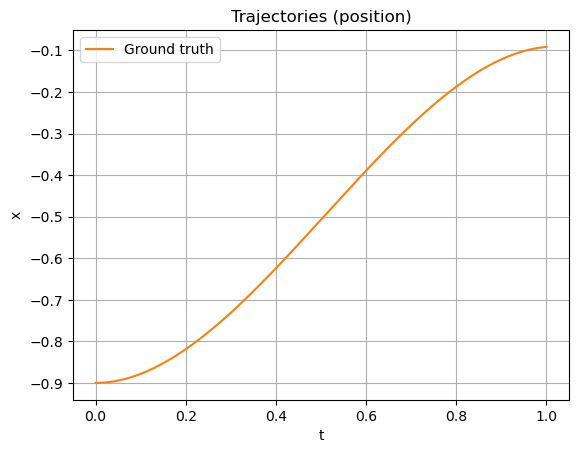

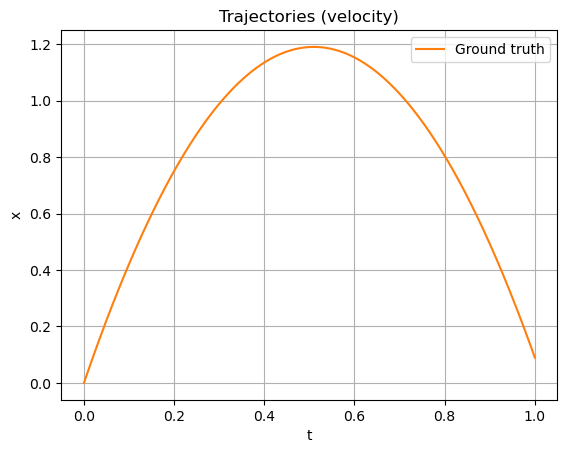

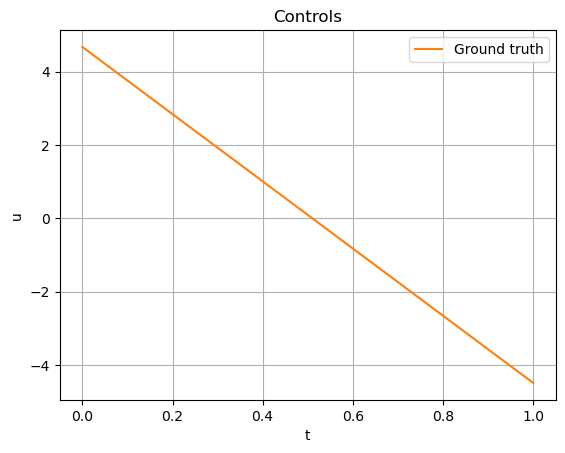

Approximation of the optimal cost: 8.244808845849274


In [6]:
gt_x, gt_x_dot, gt_u = ground_truth_sample(x_0=-0.9)
plot_trajectory(gt_x=gt_x)
plot_trajectory(gt_x=gt_x_dot, title="velocity")
plot_control(gt_u=gt_u)
print("Approximation of the optimal cost:", cost(gt_x, gt_x_dot, gt_u))

---

# Numerical discretization of the problem

Let's discretize the system in time; this discretization will be used to implement a simulator for the system of interest, but also to look for the control $\tf u$ in a subset of all possible functions in the methods presented below. This discretization in time will serve for all numerical methods implemented below.

Let $N \in \N^*$ be the discretization resolution and $\Delta t = \frac{T}{N}$ the time step. Let $\forall n \in \intset{0}{N}, \ t_n = n \Delta t, \  u_n = \tf u(t_n)$ (arbitrarily taking $u_N=0$), $x_n = \tf x(t_n)$ and $v_n = \dot{\tf x}(t_n)$. We also denote by $\ts x$, $\ts v$ and $\ts u$ the vectors $(x_0, ..., x_N)^\T$, $(v_0, ..., v_N)^\T$ and $(u_0, ..., u_{N-1})^\T$ .

With this discretization, we now _choose_ to search a control $\tf u$ in a subset $\U_{\Delta t} \subset \U$, namely:
$$
    \U_{\Delta t} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N-1}, u_n \in U \right\}.
$$

Moreover, we observe that for any $\tf u \in \U_{\Delta t}$ and any $n \in \intset{0}{N-1}$:
$$
\begin{aligned}
    x_{n+1} &= x_n + \int_{t_n}^{t_{n+1}} \dot{\tf x}(s) \d s\\
    &= x_n + \int_{t_n}^{t_{n+1}} \bigg( v_n + \int_{t_n}^s \ddot{\tf x}(r) \d r \bigg) \d s\\
    &= x_n + \Delta t\,v_n + \int_{t_n}^{t_{n+1}} \bigg( \int_{t_n}^s \frac{u_n}{m} \d r \bigg) \d s\\
    &= x_n + \Delta t\,v_n + \frac{{\Delta t}^2}{2m} u_n
\end{aligned}
$$
and
$$
    v_{n+1} = v_n + \frac{\Delta t}{m} u_n.
$$

Furthermore, the cost function rewrites:
$$
    J(\ts u) = \lambda_P x_N^2 + \lambda_V v_N^2 + \Delta t \sum_{n=0}^{N-1} u_n^2.
$$

In [7]:
print_current_parameters(physical_problem=False, time_discretization=True)

N: 50
DT: 0.02


## Deriving a simulator

From this discretization, in `problem.py`, we define a simulator that will represent the system under scrutiny: we will use it to simulate the interactions with the system that arise in the various algorithms detailed below.

This simulator takes as argument a policy, which is a function of $x$ and/or $t$ that represents our control. It proceeds in a "time-marching" manner as it iteratively enforces the _dynamics_ $\P : \Omega \times \V \times U \to \Omega \times \V$ defined by:
$$
    \P(x, v, u)
     = \begin{pmatrix} \P_x(x, v, u) \\ \P_v(v, u) \end{pmatrix}
     =\begin{pmatrix} x + \Delta t\,v + \frac{{\Delta t}^2}{2m} u \\ v + \frac{\Delta t}{m} u \end{pmatrix}.
$$
In other words, this `dynamics` function takes as arguments a position $x$, a velocity $v$ and an action $u$ and returns the new position and velocity, computed by integrating the equations of the dynamic (with $\tf u$ considered cosntant on the time interval) starting from $x$ and $v$.

At each time step, the simulator feeds the current state into the policy to generate an action that is passed to the dynamics; the latter outputs the new state that is used for the following step.
Lastly, the simulator outputs the trajectory, that is the array of positions at the end of each time interval.

---

# Solving by adjoint method

Let's now assume that we don't have an analytical solution. How can we solve this control problem? Strictly following optimal control theory, we would have to solve an inverse problem to fit a model and determine $m$ thereby. From there, we can use one of the conventional methods described below.

## Finding the model

Before applying control algorithms, we need to identify the mass $m$. This is an instance of a _system identification_ problem. This discipline consists in matching a theoretical model to a system that you want to control. Various methods exist depending on the level of knowledge of the system: full knowledge of the system (white box), no knowledge (black box) or partial knowledge (grey box). When a model is available, white box approaches are usually more efficient, but such models are usually very costly to find. This is why many applications actually resort to black box systems which leverage tools out-of-the box like the autoregressive models and more recently deep neural networks to find a structure for the model to identify. However, fitting the data requires a lot of data and computations, especialy for highly non-linear problems.

Regardless of the method chosen, the identification process can be divided into 4 steps:

1. __Data gathering__ consists in collecting (ideally) input-output pairs (or only output samples if the system doesn't take inputs) that are representative of the system's behaviour. Inputs should be chosen in the widest range possible to explore the system well.

2. __Model postulate__ makes a guess for the mathematical structure of the model, that is the class of functions in which the model should be searched. In the case of a black-box approach, this structure should be as generic as possible.

3. __Parameter identification__ fine-tunes the parameters to particularize the identified model searched in the class of functions defined in the previous step.

4. __Model validation__ confirms that the identified system corresponds to new data, usually chosen differently from the data used for the identification.

For simplicity, in this section, we will assume that we already have the structure of the model identified (which could be proposed, say, from Newton's laws), so step 2 should be straightforward. Then, step 3 will consist in finding the correct mass $m$, which we will do by least squares regression. 
Gathering data for steps 1 and 4 will be carried out using the simulator.

### Data generation

Data is generated using the simulator. The trajectories returned by the latter will be used as samples, _i.e._ observations of the system for model identification. Note that we could have chosen a sampling time-step for the state different from that for the control, but it seems reasonable to assume that we are able to observe the state of the cart at the same pace as we adjust the force upon it.

In this simple case, sampling one trajectory for a constant action should be enough, and we can just apply a quadratic regression. Indeed, for a constant force $u$ and a known initial position $x_0$:
$$
    \tf x(t) = \frac{u}{2m} t^2 + x_0
$$
So, we just need to determine the coefficient $a$ in the polynomial $\tf x(t) = a t^2 + b t + c$.

In [8]:
wt_0 = time.time()
x_0 = -0.9
t = np.linspace(0, 1, N+1)
u = 1
identification_data, _ = simulator(x_0, lambda t, x, v: u)
regression_polynomial = np.polyfit(t, identification_data, deg=2)
M_ESTIMATED = u/(2*regression_polynomial[0])
wt_1 = time.time()
print("Polynomial obtained from the regression:", regression_polynomial)
print("Estimated mass:", M_ESTIMATED)
print("Elapsed time:", wt_1 - wt_0)
print("Number of samples used:", identification_data.shape[0])

Polynomial obtained from the regression: [ 5.00000000e-01 -9.69775614e-16 -9.00000000e-01]
Estimated mass: 1.000000000000002
Elapsed time: 0.0015740394592285156
Number of samples used: 51


We see that we get the exact mass, up to the numerical errors. Here the process is very fast, simple and data-efficient because the model is very simple (we already know the mathematical structure of the model) and the simulator is noise-less.

### Validation

Validation sounds a bit artificial here, but let's illsutrate it anyway. From the model we identified, we could create a simulator:

In [9]:
def inferred_dynamics(x, v, u):
    return x + DT*v + DT**2/(2*M_ESTIMATED)*u, v + DT/M_ESTIMATED*u

def inferred_simulator(x_0, control):
    x = np.zeros(N+1)
    x[0] = x_0
    v = 0
    for n in range(N):
        x[n+1], v = inferred_dynamics(x[n], v, control(n*DT))
    return x

Then, we can compare the trajectory samples returned by this inferred simulator for a different control, with the samples returned by the actual system for this control; more precisely, we can compute the empirical risk using the mean squared error as the risk function:

In [10]:
wt_0 = time.time()
x_0 = -0.4
t = np.linspace(0, 1, N+1)
control = lambda t: 3*t
validation_data, _ = simulator(x_0, lambda t, x, v: control(t))
simulated_data = inferred_simulator(x_0, control)
mse = np.mean((validation_data - simulated_data)**2)
wt_1 = time.time()
print("Mean squared error:", mse)
print("Elapsed time:", wt_1 - wt_0)
print("Number of samples used:", validation_data.shape[0])

Mean squared error: 1.1713585283766085e-31
Elapsed time: 0.00047469139099121094
Number of samples used: 51


This is a reasonable risk compared to the expected scales for the position or to the precision that we can reasonably hope to achieve on the final position. We could carry out more rigorous stastical studies, but we'll content ourselves with this rough validation.

## Solving the optimal control problem by adjoint method

With this model in hand, optimal control theory comes with a whole range of methods to tackle problems of different kinds. Here for illustration, we assume that we don't have an analytical solution and we use the adjoint method. The idea is simply to apply a gradient descent to minimize the functional $J$. For simple problems like this one, we could directly work out an analytical expression of the gradient of $J$ (here seen as a function of the time series $\ts u$, so as a function from $U^N$ to $\R$), but for harder problems this would be a daunting task because of the terms $x_N$ and $\dot{x}_N$ which need integrating the ODE over the whole time period. We could approximate this gradient by finite difference, but then we would need to integrate the state equation in all directions of $\U_{\Delta t}$. One way to ease this computation is to get an implicit expression through the computation of the adjoint state $\tf p$. Therefore, evaluating the gradient only requires integrating the state equation once (to get the final state on $\tf p$) and the co-state equation once (to get the value of $\tf p$ over the full time period).

Let's illustrate this method for our example, starting with a small proof for the expression of the gradient.

Remembering the formulation as an LQR, the cost writes:
$$
    J(\tf u) = \int_0^T (\tf u(t)^\T \mat R \tf u(t)) \dd t + \tf y(T)^\T \mat D \tf y(T)
$$
with
$$
    \mat R = 1 \qquad   \text{and}  \qquad \mat D = \begin{pmatrix}
        \lambda_P & 0\\
        0 & \lambda_V
    \end{pmatrix}
$$
subject to:
$$
\begin{cases}
    \dot{\tf y}(t) = \mat A \tf y(t) + \mat B \tf u(t) & \forall t \in [0, T],\\
    \tf y(0) = (0, 0)^\T,
\end{cases}
$$
with
$$
    \forall t \in [0, T], \ \tf y(t) = \begin{pmatrix}
        \tf x(t)\\
        \dot{\tf x}(t)
    \end{pmatrix}, \qquad
    \mat A = \begin{pmatrix}
        0 & 1\\
        0 & 0
    \end{pmatrix} \qquad    \text{and}     \qquad
    \mat B = \frac{1}{m} \begin{pmatrix}
        0\\
        1
    \end{pmatrix}.
$$
We see that $J$ can be decomposed into $J = J_R + J_D$ with:
$$
    J_R(\tf u) = \lVert \tf u \rVert_{L^2} \quad \text{and} \quad J_D(\tf u) = \tf y(T)^\T \mat D \tf y(T).
$$
It is easily shown that $\nabla_\tf u J_R = 2 \tf u$.

To compute the gradient of $J_{D}$, this time we want to avoid having to compute $\nabla_\tf u \tf y(T)$. Let's consider a small perturbation of the control $\delta\tf u \in L^2([0, T], U)$ and let's introduce $\tf y_{\tf u + \delta \tf u}$ associated to the control $\tf u + \delta \tf u$. Then, by linearity of the state equation:
$$
    \tf y_{\tf u + \delta\tf u} = \tf y_\tf u + \delta \tf y \quad \text{with} \quad \delta \dot{\tf y} = \mat A \delta \tf y + \mat B \delta \tf u.
$$
So, since $\mat D$ is symmetric:
$$
\begin{align*}
    J_D(\tf u + \delta \tf u) & = \tf y_{\tf u+\delta \tf u} (T)^\T \mat D \tf y_{\tf u +\delta \tf u} (T)^{\T} \\
     & = \tf y_\tf u(T)^\T \mat D \tf y_\tf u(T) + 2 \tf y_\tf u(T)^\T \mat D\,\delta \tf y(T) + \delta \tf y(T)^\T \mat D\,\delta \tf y(T).
\end{align*}
$$
Now, by Duhamel's formula with $\delta \tf y(0) = 0$:
$$
    \delta \tf y(t) = \int_0^t e^{(t-s) \mat A} \mat B \delta \tf u(s) \d s,
$$
hence $\lVert \delta \tf y \rVert_{C^0} \leq C \rVert \delta \tf u \rVert_{L^2}$ with $C$ a constant that does not depend on $\delta \tf u$.

Furthermore, since
$
D=\begin{pmatrix}
    \lambda_P & 0 \\
    0 & \lambda_V
\end{pmatrix}$, then $\lvert \delta \tf y(T)^\T \mat D \delta \tf y(T) \rvert^2 \leq \max(\lambda_P, \lambda_V)  \lvert \delta \tf y(T) \rvert^2  \leq C \max(\lambda_P, \lambda_V)$. So, $\delta \tf y(T)^\T \mat D\,\delta \tf y(T) = o(\delta \tf u)$.

Therefore:
$$
\begin{align*}
    J_D(\tf u + \delta \tf u) & = J_D(\tf u) + 2 \tf y_\tf u(T)^\T \mat D\,\delta \tf y(T) + o(\delta \tf u),
\end{align*}
$$
hence $\forall \tf u \in L^2([0, T], U)$,
$$
    \langle \nabla J_D(\tf u), \delta \tf u \rangle = 2 \tf y_\tf u(T)^\T \mat D\,\delta \tf y(T)
$$
Remembering the definition of the adjoint system for the LQR:
$$
\begin{cases}
    \dot{\tf p}(t) = - \mat A^\T \tf p\\
    \tf p(T) = \mat D \tf y_\tf u(T),
\end{cases}
$$
we have:
$$
\begin{align*}
    \langle \nabla J_{D}(\tf p), \delta \tf u \rangle & = 2 \delta \tf y(T)^\T \tf p(T)\\
     & = 2 [\delta \tf y(t)^\T \tf p(t)]_0^T\\
     & = 2 \int_0^T \frac{\d}{\d t}\big(\delta \tf y(t)^\T \tf p(t)\big) \d t\\
     & = 2 \int_0^T \big[\delta \dot{\tf y}(t)^\T \tf p(t) + \delta \tf y(t)^\T \dot{\tf p}(t) \big] \d t\\
     & = 2 \int_0^T \big[(\mat A \delta \tf y(t) + \mat B \delta \tf u(t))^\T \tf p(t) - \delta \tf y(t)^\T \mat A^\T \tf p(t) \big] \d t\\
     & = 2 \int_0^T \delta \tf u(t)^\T \mat B^\T \tf p(t)\,\d t\\
     & = \langle 2 \mat B^\T \tf p, \delta \tf u \rangle
\end{align*}
$$
Therefore, the gradient of $J$ is:
$$
    \boxed{\nabla J(\tf u) = 2 \tf u + 2 \mat B^\T \tf p}
$$
We just obtained an expression of the gradient that doesn't need the gradient of $\tf y(t)$ w.r.t. $\tf u$, but this computation requires to integrate the state ODE (to get $\tf p(T)$) and the adjoint ODE to compute $\tf p$. For higher dimensions, this could be quite costly, but not as much as approximating the gradient by finite difference.

To get the state and adjoint state trajectories, let's use the Euler integration scheme. For the state trajectory:
$$
\begin{align*}
    y_{n+1} & = y_n + \int_{t_n}^{t_{n+1}} \big( \mat A \tf y(t) + \mat B \tf u(t) \big) \d t \\
     & \approx y_n + \Delta t \big( \mat A y_n + \mat B u_n \big).
\end{align*}
$$

Likewise, denoting $\forall n \in \intset{0}{N}, \ p_n = \tf p(t_n)$:
$$
\begin{align*}
    p_{n+1} & = p_n - \int_{t_n}^{t_{n+1}} \mat A^\T \tf p(t) \d t \\
     & \approx p_n - \Delta t \mat A^\T p_{n+1},
\end{align*}
$$
so:
$$
    p_n \approx p_{n+1} + \Delta t \mat A^\T p_{n+1}.
$$

In [11]:
def euler_simulator(x_0, u, m, dt=DT):
    """ Compute the trajectory using explicit Euler method. """
    n_samples = int(T/dt)
    y = np.zeros((n_samples+1, 2))
    A = np.array([[0, 1], [0, 0]])
    B = 1/m * np.array([[0], [1]])
    u = np.expand_dims(u, axis=-1)
    y[0, 0] = x_0
    for n in range(n_samples):
        y[n+1] = y[n] + dt*(A@y[n] + B@u[n])
    return y

def euler_adjoint_simulator(p_T, dt=DT):
    """ Compute the adjoint trajectory using backward Euler method. """
    n_samples = int(T/dt)
    p = np.zeros((n_samples+1, 2))
    A_T = np.array([[0, 0], [1, 0]])
    p[-1] = p_T
    for n in range(n_samples-1, -1, -1):
        p[n] = p[n+1] + dt*A_T@p[n+1]
    return p

def grad_J_adjoint(u, x_0, m, dt=DT):
    """ Gradient of the cost function w.r.t. u evaluated in u, for an initial condition x_0, using the adjoint method. """
    B = 1/m * np.array([[0], [1]])
    D = np.array([[LAMBDA_P, 0], [0, LAMBDA_V]])
    y = euler_simulator(x_0, u, m, dt=dt)
    p = euler_adjoint_simulator(D@y[-1], dt=dt)
    return 2*u + 2*np.dot(B.T, p.T)[0, :-1]

         Current function value: 8.231708
         Iterations: 25
         Function evaluations: 140
         Gradient evaluations: 128
Elapsed time: 0.12529611587524414


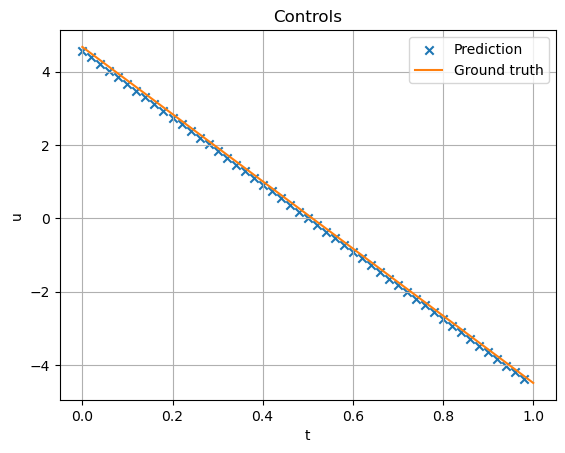

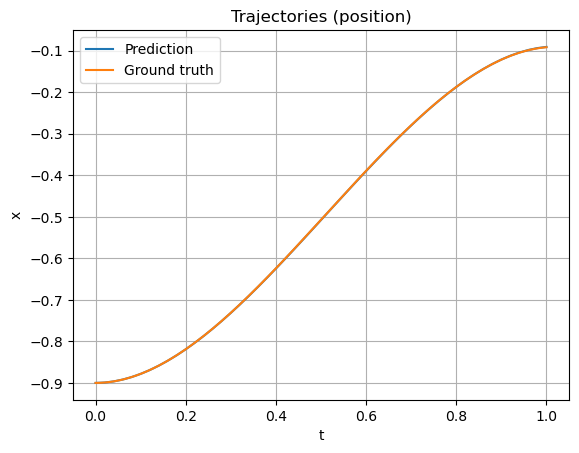

Final cost achieved by the adjoint method: 8.231708147532897
Analytical cost: 8.244808845849274


In [12]:
def solve_by_bfgs_adjoint_method(x_0, m, dt=DT):
    """ Solves the control problem using BFGS, with initial condition x_0 and estimated mass m, and using the adjoint method to compute the gradient of J. """
    res = minimize(lambda u: J(u, x_0, m, dt=dt), np.zeros(round(T/dt)), method='BFGS', jac=lambda u: grad_J_adjoint(u, x_0, m, dt=dt), options={'disp': True})
    return res.x

x_0 = -0.9

wt_0 = time.time()
adjoint_bfgs_u = solve_by_bfgs_adjoint_method(x_0, M_ESTIMATED)
wt_1 = time.time()
print("Elapsed time:", wt_1 - wt_0)

# Let's compare with the analytical solution
gt_x, gt_v, gt_u = ground_truth_sample(x_0=x_0)
plot_control(predicted_u=adjoint_bfgs_u, gt_u=gt_u,)

# To get the associated trajectory history, we need to apply the control we obtained on the system
adjoint_bfgs_policy = lambda t, x, v: adjoint_bfgs_u[int(t/T*adjoint_bfgs_u.shape[0])]
adjoint_bfgs_x, _ = simulator(x_0, adjoint_bfgs_policy)
plot_trajectory(adjoint_bfgs_x, gt_x=gt_x)
print("Final cost achieved by the adjoint method:", J(adjoint_bfgs_u, x_0=x_0, m=M_REAL))
print("Analytical cost:", cost(gt_x, gt_v, gt_u))

## Discussion on optimal control methods

With this simple example, we exemplified the use of numerical methods in optimal control, and in particular the adjoint method. From this illustration we can distinguish two prominent aspects of the method employed, which are also shared with most optimal control methods:
- The adjoint method requires getting a model for the system through model identification. In our example, this process was quite straightforward considering the hypotheses that we've made. But for real complex systems, this could be quite cumbersome or even untractable. Depending on the accuracy that you want to achieve, getting a "white-box" model necessitates a thorough study of the system under scrutiny and some data to identify and validate the parameters involved. You could also resort to a "black-box" identification, but this would require a lot of data.
- For each instance of the problem (that is for each value of $x_0$), we have to run the entire algorithm, which can take significant time and make the method unusable in real-time.

We will now implement an RL algorithm to see how RL can alleviate these issues by offering a _model-free_ approach and leveraging the pay-offline-earn-online balance.

---

# Solving by dynamic programming

Before moving to the RL implementation, let's illustrate that this problem can be solved exactly by dynamic programming (DP).
To that aim, since we will be using discrete DP here, we need discrete states, so we need not only to discretize the problem in time, but also in space, velocity and action.

For consistency, we choose the same discretization in time as for the integration of the state ODE.

As for the action space, we arbitrarily restrain $U$ to $\tilde{U} = [U_l, U_r]$ (with $U_l \in \mathbb{Z}^-$ and $U_r \in \mathbb{Z}^+$) and $\U$ to $\tilde{\U} = L^1\big( [0, T],  \tilde{U} \big)$. Since the velocity will also be part of the state, we also need to restrain it. We do so to $\tilde{\V} = [\V_l, \V_r] = [\frac{U_l}{m}\,T, \frac{U_r}{m}\,T]$ which is a natural choice because it is the set $E(T) = \{v \in \R | \exists u \in \tilde{\U}, \ \dot{\tf x}_u(T) = v \} $ of reachable velocities from $0$ and in time $T$.

Let's introduce $N_\V$ and $N_U$ the discretization resolutions for $\tilde{\V}$ and $\tilde{U}$, and $\Delta v = \frac{1}{N_\V}$ and $\Delta u = \frac{1}{N_U}$. For consistency, if we want the minimal gap between 2 discretized velocities to coincide with the minimal possible step taken by the system, we should choose $\Delta v = \P_v(v, \Delta u) - v = \frac{\Delta u}{m}\Delta t$ (where $v$ is some vector of $\V$).

Likewise, we restrain the position to $\tilde{\Omega} = [\Omega_l, \Omega_r] = [-1 + \frac{U_l}{2m}\,T^2, \frac{U_r}{2m}\,T^2]$, and we define $\Delta x = \min\left\{\P_x(x, k_v \Delta v, k_u \Delta u) - x \ \right| \left. k_v \in \mathbb{Z}, \ k_u \in \mathbb{Z}, \ \P_x(x, k_v \Delta v, k_u \Delta u) - x \neq 0 \right\} = \P_x(x, 0, \Delta u) - x = \frac{\Delta u}{2 m} {\Delta t}^2$ (where $x$ is some vector of $\Omega$) and $N_\Omega = \frac{1}{\Delta x}$.

We now look for $u$ in
$$
    \tilde{\U}_{\Delta t, \Delta u} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N}, u_n \in \tilde{U}_{\Delta u} \right\},
$$
where
$$
    \tilde{U}_{\Delta u} = \{U_l, U_l + \Delta u, ..., U_r\}
$$
(so $|\tilde{U}_{\Delta u}| = (U_r - U_l)N_U + 1$).

Likewise, the $v_n, \ n \in \intset{0}{N}$, will be confined in:
$$
    \tilde{\V}_{\Delta v} = \{ \V_l, \V_l + \Delta v, ..., \V_r \}
$$
(so $|\tilde{\V}_{\Delta v}| = (\V_r - \V_l)N_\V + 1$), and for a correctly truncated $x_0$, with our choice of $\tilde{\U}_{\Delta t, \Delta u}$, the $x_n, \ n \in \intset{0}{N}$, will be confined in:
$$
    \tilde{\Omega}_{\Delta x} = \{ \Omega_l, \Omega_l + \Delta x, ..., \Omega_r \}
$$
(so $|\tilde{\Omega}_{\Delta x}| = (\Omega_r - \Omega_l)N_\Omega + 1$).

The minimization problem is now:
$$
    \min_{\ts u \in (\tilde{U}_{\Delta u})^N} \lambda_P x_N^2 + \lambda_V v_N^2 + \Delta t \sum_{n=0}^{N-1} u_n^2.
$$

For coding reasons, we also need the state and the action to be integers that can be interpreted as indices for an array. So, the position, velocity and action will live in:
$$
    \tilde{\Omega}_{\Delta x}^{arr} = \{ 0, \Delta x, ..., (\Omega_r - \Omega_l) N_\Omega \Delta x \},
$$
$$
    \tilde{\V}_{\Delta v}^{arr} = \{ 0, \Delta v, ..., (\V_r - \V_l) N_\V \Delta v \}
$$
and
$$
    \tilde{U}_{\Delta u}^{arr} = \{ 0, \Delta u, ..., (U_r - U_l) N_U \Delta u \}
$$
respectively. We define functions to easily switch from one representation to another, namely the $\phi_{z \to z^{arr}}$ to go from $\tilde{Z}_{\Delta z}$ to $\tilde{Z}_{\Delta z}^{arr}$ where $z$ denotes $x$, $v$ or $u$ and $Z$ denotes $\Omega$, $\V$ or $U$. We also define their inverses $\phi_{z^{arr} \to z}$.

From there, we suggest the following DP formulation of the problem.
- State space: $S = \tilde{\Omega}_{\Delta x} \times \tilde{\V}_{\Delta v}$. A state is $s=(x, v) \in S$ and represents the position of the cart and its velocity at a given time step.
- Action space $A = \tilde{U}_{\Delta u} $. An action is $a \in A$ and is a representation of the control $u$ at a given time step.
- Dynamics: $\P$, in other words the physical system itself.
- Running reward function: $\forall n \in \intset{0}{N-1}, \ r_n(s, a) \equiv r(s, a) = -\Delta t \, a^2$.
- Final reward function: $r_N(x_N, v_N) = \lambda_P x_N^2 + \lambda_V v_N^2 $.

Note that since the problem is of finite time-horizon, the value function $V$ and the policy $\pi$ will also depend on time.

Before diving into the implementation, let's take a look at the complexity of the DP algorithm in this case. Define an elementary operation as either computing a transition (next state and running reward) or accessing a value in an array like $V$. Then the complexity is in $\mathcal{O}(N \times |S| \times |A|)$. Now, $|S| = |\tilde{\Omega}_{\Delta x}| |\tilde{\V}_{\Delta v}|$ where $|\tilde{\V}_{\Delta v}| = \mathcal{O} \big( (U_r - U_l) N N_U \big)$ and $|\tilde{\Omega}_{\Delta x}| = \mathcal{O} \big( (1 + \frac{2m}{T^2 (U_r - U_l)})(U_r - U_l) N^2 N_U \big)$, so $|S| = \mathcal{O} \big((1 + \frac{2m}{T^2 (U_r - U_l)})(U_r - U_l)^2 N^3 {N_U}^2 \big)$.

Therefore, the complexity is in $\mathcal{O}\big( (1 + \frac{2m}{T^2 (U_r - U_l)})(U_r - U_l)^3 N^4 {N_U}^3 \big)$.

To make the problem solvable in reasonable time, let's reduce the resolution in time and choose a coarse resolution for $\ts u$:

In [24]:
params.update_time_parameters(new_N=8)
refresh_parameters()

In [25]:
print_current_parameters(physical_problem=False, time_discretization=True, space_action_discretizations=True)

N: 8
DT: 0.125
U_L: -6
U_R: 6
N_U: 3
V_L: -6.0
V_R: 6.0
N_V: 24
X_L: -4.0
X_R: 3.0
N_X: 384


In `dp-rl.py`, we define the functions for the cost, but also to rule out the evaluation of states that can't be reached in practice starting from $x_0$ in $[-1, 0]$.

In [ ]:
# Solve by DP
X_size = int((X_R - X_L)*N_X)+1
V_size = int((V_R - V_L)*N_V)+1
U_size = int((U_R - U_L)*N_U)+1

wt_0 = time.time()

action_space = np.arange(U_L, U_R+DU, DU)
V = np.inf*np.ones((N+1, X_size, V_size))
optimal_policy_array = np.inf*np.ones((N, X_size, V_size))
for x in reachable_x(T):
    for v in reachable_v(T):
        V[-1, to_arr_x(x), to_arr_v(v)] = final_cost(x, v) 
for n in range(N-1, -1, -1):
    for x in reachable_x(n*DT):
        for v in reachable_v(n*DT):
            costs = np.array([running_cost(x, v, a) for a in action_space])
            next_Vs = np.array([V[n+1, to_arr_x(x_new), to_arr_v(v_new)] for a in action_space for (x_new, v_new) in [dynamics(x, v, a)]])
            optimal_a_arr = np.argmin(costs + next_Vs)
            V[n, to_arr_x(x), to_arr_v(v)] = costs[optimal_a_arr] + next_Vs[optimal_a_arr]
            optimal_policy_array[n, to_arr_x(x), to_arr_v(v)] = from_arr_a(optimal_a_arr)
optimal_policy = lambda t, x, v: optimal_policy_array[round(t/DT), to_arr_x(x), to_arr_v(v)]

wt_1 = time.time()
print(f"Elapsed time: {wt_1 - wt_0}s")

Elapsed_time: 506.9321494102478s


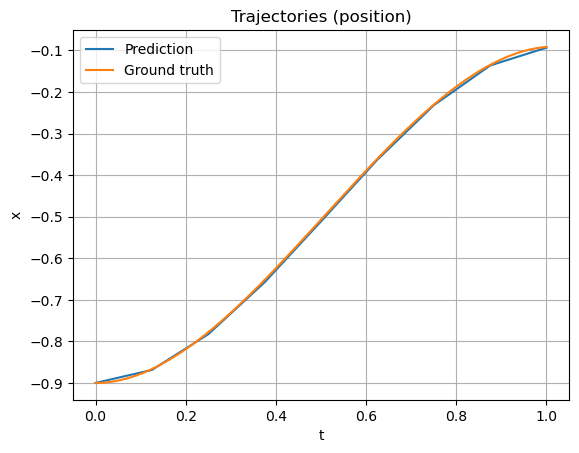

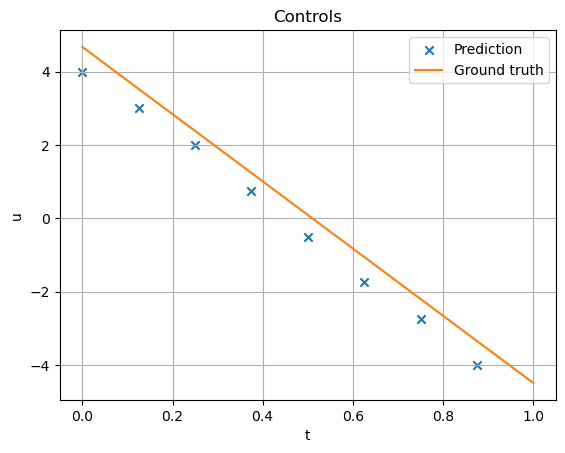

In [ ]:
# Visualize DP solution
x_0=-0.9
dp_x, dp_u = simulator(x_0, policy=optimal_policy)
gt_x, _, gt_u = ground_truth_sample(x_0)
plot_trajectory(predicted_x=dp_x, gt_x=gt_x)
plot_control(predicted_u=dp_u, gt_u=gt_u)

This method gives optimal results for the choice of discretization parameters. Even for this coarse scheme, the program took 8 minutes to run, that is 3700 more time than the adjoint method! Finer discretization steps might lead to exploding running times, and this is due to the curse of dimensionality well observed on the complexity computed above. Indeed, here the state has 2 dimensions, that of position and that of velocity. The resolution of these dimensions is based on the resolution of the action according to our discretization scheme. If the position space was of two dimensions (_e.g._ if our cart could move in a plane), this method would be untractable.

However, we just showed that dynamic programming can offer the correct framing to solve this problem, and so RL should be appropriate as well. Indeed, several RL algorithms can be seen as an approximation of DP, precisely to circumvent the curse of dimensionality.

Before going to the next section, note that dynamic programming has the benefit of being visualizable to get some interpretation of the solution. The following plots show the value function in a (velocity, time) axis for various fixed positions. Unsurprisingly, when far away from the target position at early stages, it is advantageous to have a great velocity to be able to close the gap with the target position. However, for later stages, even when still far from the target, it is not advantageous to have to high a velocity, probably because in this case the cost to slow down the cart and avoid the cost on final velocity becomes too high. Lastly, when close enough to reach the target until the end of the process, it makes sense to aim for velocities small enough to reach the target without overshooting it, while still minimizing future efforts to slw the cart down.

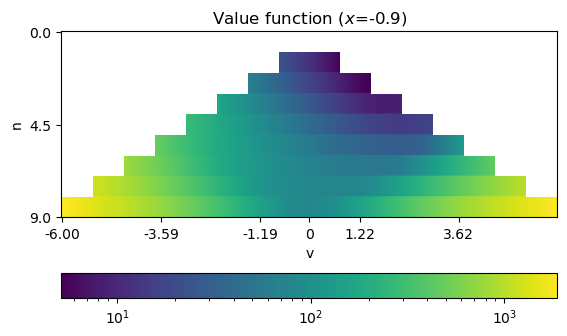

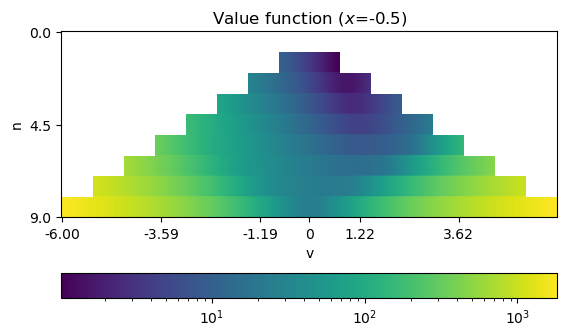

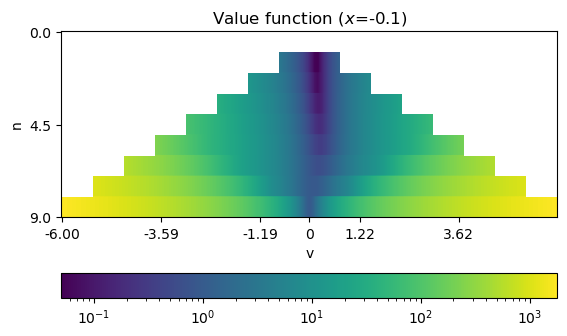

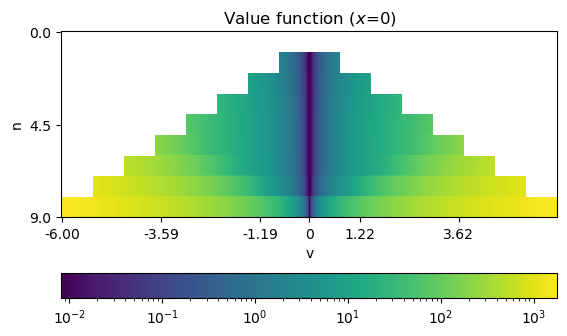

In [ ]:
for x in [-0.9, -0.5, -0.1, 0]:
    plot_V_v(V, x=x, zoom_time=4)

---

# Solving by reinforcement learning

## Choice of an algorithm

To solve the problem using RL we will use the PPO (Proximal Policy Optimization) algorithm allows to work with continuous state and action spaces. Although little convergence results are known concerning PPO to this day, it empirically achieves fast convergence for a range of different problems. It also has the benefit of leveraging parallelization of computations on multiple computer threads during the training of the RL agent. It is an actor-critic algorithm, meaning that it involves two components typically represented by deep neural networks (DNN):

- the actor (of parameters $\theta$) is a function $\mu_\theta: S \to S$ that is used to build a probabilistic policy $\pi(\cdot;\theta)$(_i.e._ it maps each state to a probability distribution), and the probability of choosing action $a$ when in state $s$ is $\pi(a; s, \theta)$.
-  the critic (of parameters $\phi$) is an estimate $V(s; \phi)$ of the value function associated to $\pi(\cdot|\theta)$.

In a typical implementation of PPO, $\pi(\cdot; s, \theta)$ is a Gaussian distribution whose mean is $\mu_\theta(s)$. The variance of the distribution accounts for the amount of exploration in this algorithm, and this variance is progressively decreased to end up with a deterministic policy.
With this policy in hand, a naive approach would consist in expressing the expected value of the cumulative reward $\mathbb{E}_{\theta} \left[ \sum_{t=0}^{T-1} r_t(s, A_t) \right]$ as a function of $\theta$ and directly maximizing it. Instead, after each episode (or batch of episodes), the critic is used to build a surrogate objective that will be maximized. This surrogate objective measures how much a new value of $\theta$ improves on the current policy with regard to the accumulated rewards, while preventing steep changes in this policy that could harm the algorithm's robustness.

## Formulation

The formulation is very close to that proposed for dynamic programming, with the difference that the state and action spaces will be continuous, although actions are still restrained to a bounded set.
- State space: $S = \Omega \times \V$. A state is $s=(x, v) \in S$ and represents the position of the cart and its velocity at a given time step.
- Action space $A = \tilde{U}$. An action is $a \in A$ and is a representation of the control $u$ at a given time step.
- Dynamics: $\P$, in other words the physical system itself.
- Running reward function: $\forall n \in \intset{0}{N-1}, \ r_n(s, a) \equiv r(s, a) = -\Delta t \, a^2$.
- Final reward function: $r_N(x_N, v_N) = \lambda_P x_N^2 + \lambda_V v_N^2 $.

Furthermore, we can fall back to a finer discretization in time for the problem. The timestep should be chosen small enough for the precision to be satisfying, but too many timesteps makes the problem artificially longer: since time is implicitly part of the observation space, the latter grows bigger as the number of time steps grows, and more generally the final reward becomes further away in steps, which is known to make problems more difficult because the reward signal have to be propagated back to early steps.

In [13]:
update_time_parameters(new_N=50)
refresh_parameters()

## Implementation

For the implementation, we will be using `stable-baselines3`, which is based on Farama's `gymnasium`. This requires creating a custom environment for our problem, so let's do that.

### Creating the environment

In [14]:
class CartEnv(gym.Env):
    """ Environment for the accelarated cart problem. See gymnasium documentation for further details. """
    metadata = {"render_modes": ["human"]}
    
    def __init__(self, render_mode=None):
        # Observation space is time, position and velocity.
        self.observation_space = gym.spaces.Dict(
            {
                "cart_state": gym.spaces.Box(-np.inf, np.inf, shape=(2,), dtype=np.float32),
                "timestep": gym.spaces.Discrete(N+1),
            }
        )
        # Action space is Boxes of shape (1,), containing the action exerted on the cart.
        self.action_space = gym.spaces.Box(U_L, U_R, shape=(1,), dtype=np.float32)
        self.timestep = 0  # Current timestep
        self.x_0 = None  # Initial position of the cart
        self.x, self.x_dot = None, None  # Current position and velocity of the cart
        self.x_history = None  # For rendering
        self.v_history = None  # For rendering
        self.u_history = None  # For rendering
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
    
    def _get_obs(self):
        """ Return the current position and velocity of the cartn as well as the current time step of the evolution. """
        return dict(cart_state=np.array([self.x, self.x_dot], dtype=np.float32), timestep=self.timestep)
    
    def _get_info(self):
        return {}
    
    def reset(self, seed=None, options=None, x_0=None):
        """ Reset the environment, picking a new initial position x_0 randomly in [-1, 0] (unless x_0 is specified) and reinitializing the time step and histories of the position, velocity and control.
        Returns the initial position, velocity and time step. """
        super().reset(seed=seed)
        self.x_0 = -self.np_random.random() if x_0 is None else x_0
        self.timestep = 0
        self.x, self.x_dot = self.x_0, 0

        observation = self._get_obs()
        info = self._get_info()

        self.x_history = np.array([self.x])
        self.v_history = np.array([self.x_dot])
        self.u_history = np.array([])

        return observation, info
    
    def step(self, action):
        """ Given an action, simulates one step of the evolution and returns the new position, velocity and time step as well as the reward and an indication whether the evolution has terminated.
        Also updates the history of the position, velocity and control. """
        u = action[0]
        self.timestep += 1
        self.x, self.x_dot = dynamics(self.x, self.x_dot, u)
        truncated = self.timestep == N
        
        # Let's use the rewards already defined for dynamic programming
        reward = -final_cost(self.x, self.x_dot) if truncated else -running_cost(self.x, self.x_dot, u)
        observation = self._get_obs()
        info = self._get_info()
        
        self.x_history = np.append(self.x_history, self.x)
        self.v_history = np.append(self.v_history, self.x_dot)
        self.u_history = np.append(self.u_history, u)
        
        return observation, reward, False, truncated, info

    def render(self):
        """ Renders the evolution, plotting the trajectory in terms of position and velocity and the control over the evolution, with the analytical solution for comparison.
        Also prints the total cost, together with the cost of the analytical solution. """
        if self.render_mode == "human":
            gt_x, gt_v, gt_u = ground_truth_sample(self.x_0)
            print("Trajectory (position and velocity) and cotnrol for the terminating run:")
            plot_trajectory(predicted_x=self.x_history, gt_x=gt_x)
            plot_trajectory(predicted_x=self.v_history, gt_x=gt_v, title="velocity")
            plot_control(predicted_u=self.u_history, gt_u=gt_u)
            print("Approximate cost achieved by the agent:", cost(x=self.x_history, x_dot=self.v_history, u=self.u_history))
            print("Analytical cost:", cost(gt_x, gt_v, gt_u))

    def close(self):
        pass



# Check that this environment is correctly defined
env = CartEnv()  # The wrapper allows to make the agent aware of the current timestep through the run.
check_env(env)

/home/theilo/Software/Miniconda/envs/RL/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:417: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


To test whether the environment works well, let's run the simulation, picking random actions:

Trajectory (position and velocity) and cotnrol for the terminating run:


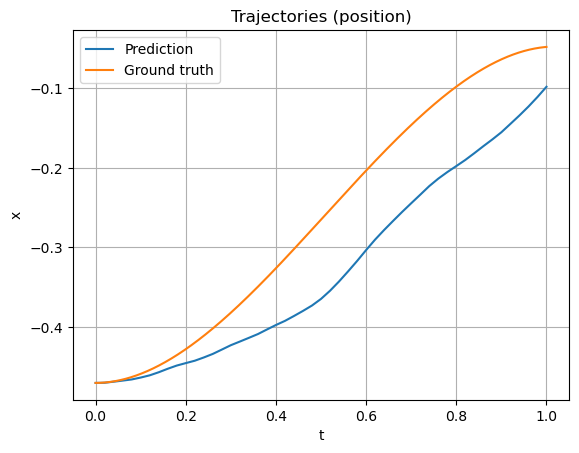

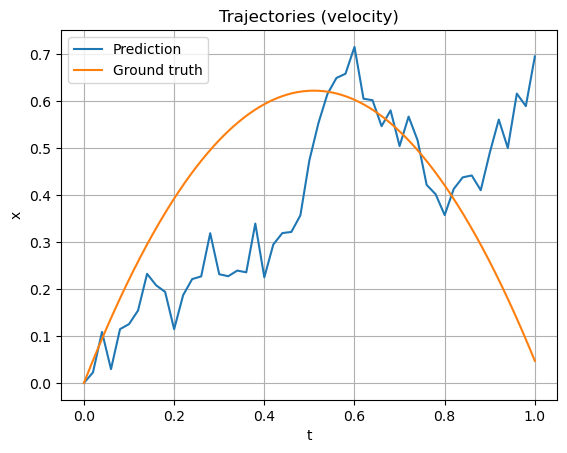

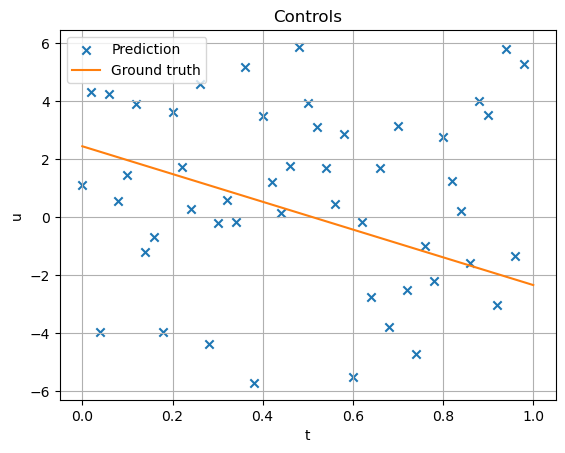

Approximate cost achieved by the agent: 34.94878584154772
Analytical cost: 2.252628664652717


In [15]:
env = CartEnv(render_mode="human")
observation, info = env.reset()
for _ in range(N):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        env.render()
        observation, info = env.reset()

env.close()

It seems to work correctly! Now, let's register this model to re-use it later:

In [16]:
# Register the environment for later usage.
env = gym.register("AcceleratedCart-v1", CartEnv)

### Training a model

In [17]:
hyperparameters = {
    "n_steps": N,
    "batch_size": 2*N,
    "learning_rate": 0.001,
    "gamma": 0.99
}

n_envs = 8
model_name = "PPO_3"  # The best trained model so far is PPO_3. If you run this notebook from Google Colab, you might have to copy the corresponding PPO_3 folder from content/RL-accelerated-cart/Agents into content/Agents
Algo = PPO
model_path, model, env = instantiate_model(model_name, Algo, hyperparameters, n_envs=n_envs)

Loading a pre-existing model.


In [ ]:
wt_0 = time.time()
train_model(model, model_path, training_steps=1_000, n_envs=n_envs, eval_freq=125)
wt_1 = time.time()
print(f"Elapsed time: {wt_1 - wt_0}s")

In [18]:
test_env = Monitor(gym.make("AcceleratedCart-v1"))
best_model = Algo.load(os.path.join(model_path, "best_model.zip"), env=test_env)
mean_reward, std_reward = evaluate_policy(best_model, test_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-6.61 +/- 5.21


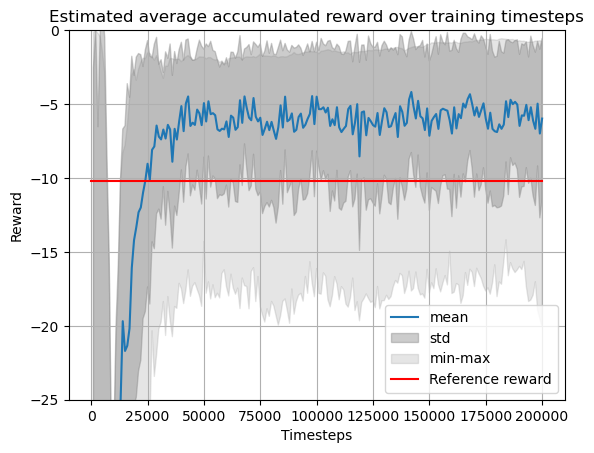

In [19]:
gt_x, gt_x_dot, gt_u = ground_truth_sample(x_0=-1)
analytical_cost = cost(gt_x, gt_x_dot, gt_u)
plot_training_evaluations(model_path, reference_reward=-analytical_cost, crop_reward=[-25, 0])

The agent seems to have learnt. The red line on this graph is the analytical score in the worst case scenario, that is if $x_0=-1$.

Let's visualize the result for $x_0 = -0.9$ and $x_0 = -0.5$:

Trajectory (position and velocity) and cotnrol for the terminating run:


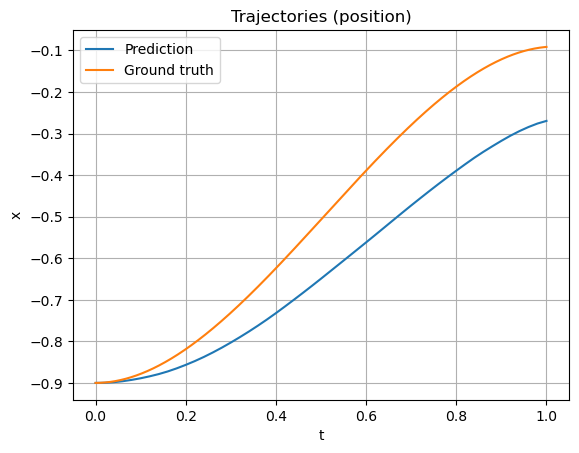

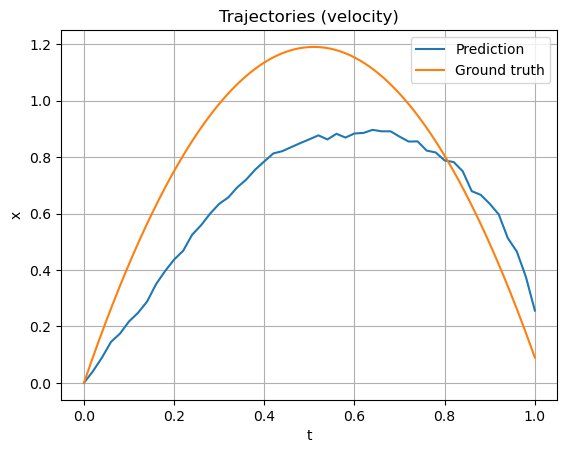

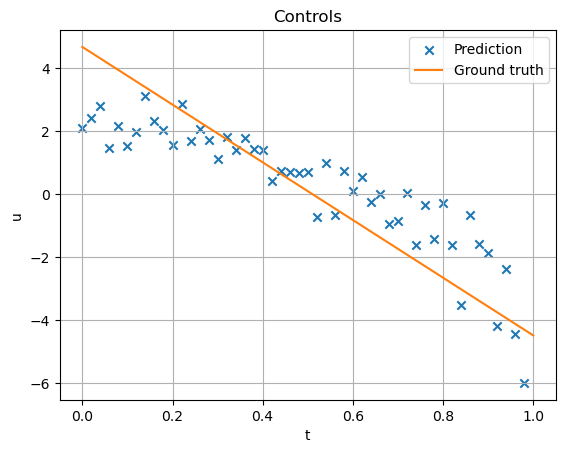

Approximate cost achieved by the agent: 14.08122725820596
Analytical cost: 8.244808845849274


In [21]:
# Evaluate after training
render_env = gym.make("AcceleratedCart-v1", render_mode="human")
observation, info = render_env.reset(x_0=-0.9)
for _ in range(N):
    action, _states = best_model.predict(observation, deterministic=True)
    observation, reward, terminated, truncated, info = render_env.step(action)
    if terminated or truncated:
        render_env.render()
        observation, info = render_env.reset()

render_env.close()

Trajectory (position and velocity) and cotnrol for the terminating run:


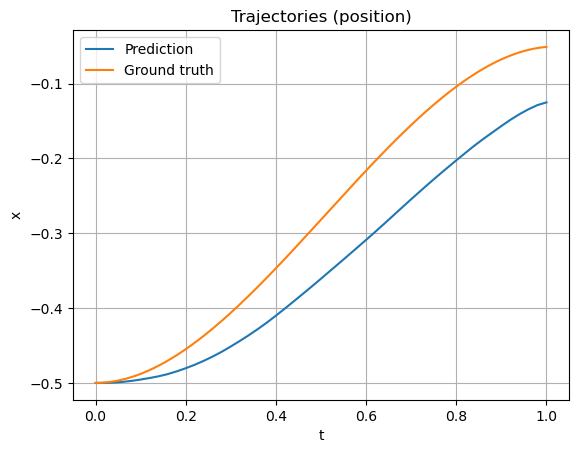

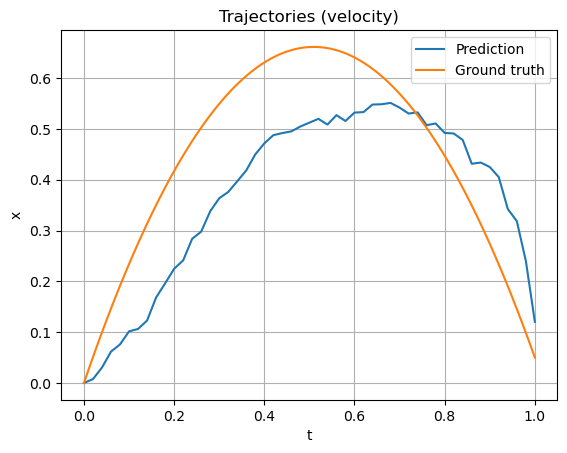

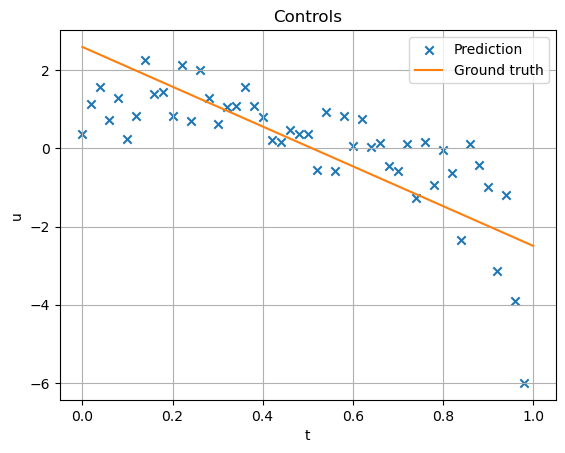

Approximate cost achieved by the agent: 4.130892296383305
Analytical cost: 2.544694088225081


In [22]:
# Evaluate after training
render_env = gym.make("AcceleratedCart-v1", render_mode="human")
observation, info = render_env.reset(x_0=-0.5)
for _ in range(N):
    action, _states = best_model.predict(observation, deterministic=True)
    observation, reward, terminated, truncated, info = render_env.step(action)
    if terminated or truncated:
        render_env.render()
        observation, info = render_env.reset()

render_env.close()

The agent gets a suboptimal result that gives a cost less than twice as big as the optimal. Note how the agent tends to start too slowly. Because of that, the trajectory curve is always below the ground truth. Also, quite some time passes until the agent starts decelerating, and thus the cart tends to accumulate too much speed until the last moment. As a result, the agent applies a strong force to avoid having a penalization on the final velocity.
All of these elements are symptoms that the agent struggles to anticipate on the long term. To alleviate that, we could of course decrease the number of timesteps, but that would be at the expense of the time precision. Instead, we could also try to fine-tune the parameters so as to make the agent "look further ahead". We could also try other algorithms to see which works best for this problem.

---

# Discussion

Let's make two remarks on the RL method we just implemented and how it compares with the adjoint method.

Firstly, for RL we didn't have to make any model identification. Of course we needed to define an environment for the agent to evolve in, but "ideally" this environment would be the real system that we are studying.

Secondly, something that wasn't obvious in the previous demonstration is the time taken by the agent to give a control, because contrary to the adjoint method, the RL agent acts as a closed-loop control that takes action on the go. Let's evaluate the time taken by the agent to take one decision:

In [35]:
test_env = gym.make("AcceleratedCart-v1")
model = Algo.load(os.path.join(model_path, "best_model.zip"), env=test_env)
observation, info = test_env.reset()
wt_0 = time.time()
action, _states = model.predict(observation, deterministic=True)
wt_1 = time.time()
print("Elapsed time:", wt_1 - wt_0)

Elapsed time: 0.0010890960693359375


Now, compare this to the time taken by the adjoint method to solve the problem:

In [36]:
wt_0 = time.time()
adjoint_bfgs_u = solve_by_bfgs_adjoint_method(x_0, M_ESTIMATED, dt=DT)
wt_1 = time.time()
print("Elapsed time:", wt_1 - wt_0)


         Current function value: 8.231708
         Iterations: 25
         Function evaluations: 136
         Gradient evaluations: 124
Elapsed time: 0.11811542510986328


We see that the time taken to make the first decision is much smaller in the case of the RL algorithm, which makes it more suitable to tackle problems in real time; in other words, the agent would be more adapted to problems where a decision has to be taken quickly after the initial state is known, at the expense of the accuracy and of the offline cost (both in terms of time and data).

To insist on this last drawback, let's emphasize that as read on the training curve above, the agent starts giving somewhat satisfactory results after about $50\,000$ samples, that is $90$ seconds of training, versus about a tenth of a second and $100$ samples (that is one entire run for data identification and one for validation) for the adjoint method, that is almost $500$ times less data samples than the RL method. As a possible further development, transfer learning can be seen as an option to circumvent the data inefficacy of RL methods by training an agent over a pre-trained one, in the hope that the initial values for the agent's parameters will allow for quicker convergence.